In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
import geopandas

In [69]:
data = pd.read_csv('dataset_flujo_vehicular.csv')

In [70]:
data

,CODIGO_LOCACION,HORA,CANTIDAD,SENTIDO,LATITUD,LONGITUD
0,48Q3CJ00+,31MAR2020:15:00:00,729,Interna,-34.588796,-58.381520
1,48Q3CJ00+,31MAR2020:15:00:00,447,Egreso,-34.588796,-58.381520
2,48Q39G00+,31MAR2020:15:00:00,175,Interna,-34.633299,-58.468594
3,48Q39G00+,31MAR2020:15:00:00,1186,Egreso,-34.633299,-58.468594
4,48Q3CH00+,31MAR2020:15:00:00,35,Egreso,-34.579632,-58.427733
...,...,...,...,...,...,...
95920,48Q3CJ00+,26JAN2021:11:00:00,2560,Egreso,-34.588796,-58.381520
95921,48Q3CJ00+,26JAN2021:11:00:00,2951,Ingreso,-34.588796,-58.381520
95922,48Q3CJ00+,26JAN2021:11:00:00,4539,Interna,-34.588796,-58.381520
95923,48Q3CJ00+,26JAN2021:12:00:00,2628,Egreso,-34.588796,-58.381520


In [71]:
# Convertimos la fecha a datetime
data.HORA = pd.to_datetime(arg=data.HORA, format='%d%b%Y:%H:%M:%S')

In [72]:
data.dtypes

CODIGO_LOCACION            object
HORA               datetime64[ns]
CANTIDAD                    int64
SENTIDO                    object
LATITUD                   float64
LONGITUD                  float64
dtype: object

In [73]:
# Creamos una columna de años
data['year'] = [d.year for d in data.HORA]
# Creamos una columna mes
data['month'] = [d.strftime('%b') for d in data.HORA]

In [74]:
# 48Q39G00+ == San Pedrito y Av. Juan Bautista Alberdi
data.CODIGO_LOCACION.value_counts()

48Q3CJ00+    26245
48Q39G00+    26054
48Q3CH00+    17367
48Q39H00+     8758
48Q39J00+     8757
48Q3FG00+     8587
2H2M2200+       79
27262200+       78
Name: CODIGO_LOCACION, dtype: int64

In [75]:
data.groupby('CODIGO_LOCACION')['CANTIDAD'].sum().sort_values(ascending=False).head()

CODIGO_LOCACION
48Q39G00+    62020183
48Q3CJ00+    42852763
48Q39J00+    34367352
48Q39H00+    34299678
48Q3CH00+    14807153
Name: CANTIDAD, dtype: int64

In [76]:
data.SENTIDO.unique()

array(['Interna', 'Egreso', 'Ingreso'], dtype=object)

In [77]:
data.LATITUD.unique()

array([-34.588796, -34.633299, -34.579632, -34.60855 , -34.53698 ,
       -34.618036,        nan])

In [78]:
data.LONGITUD.unique()

array([-58.38152 , -58.468594, -58.427733, -58.372951, -58.470968,
       -58.410236,        nan, -58.468594, -58.427733, -58.38152 ])

In [79]:
meses={
    'JAN':'01',
    'FEB':'02',
    'MAR':'03',
    'ABR':'04',
    'MAY':'05',
    'JUN':'06',
    'JUL':'07',
    'AUG':'08',
    'SEP':'09',
    'OCT':'10',
    'NOV':'11',
    'DEC':'12'
}

In [80]:
#new_date =[]
#contador = 0
#for j in data.HORA:
#    for key, value in meses.items():
#        if key in j:
#             new_date.append(data.HORA[contador].replace(key, value))
#     contador +=  1

In [81]:
# Función que plotea la serie:
def plot_df(data, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [82]:
data_v1 = data.loc[data['CODIGO_LOCACION'] == '48Q39G00+']
data_v1.reset_index(drop=True, inplace=True)
data_v1

,CODIGO_LOCACION,HORA,CANTIDAD,SENTIDO,LATITUD,LONGITUD,year,month
0,48Q39G00+,2020-03-31 15:00:00,175,Interna,-34.633299,-58.468594,2020,Mar
1,48Q39G00+,2020-03-31 15:00:00,1186,Egreso,-34.633299,-58.468594,2020,Mar
2,48Q39G00+,2020-03-31 15:00:00,1235,Ingreso,-34.633299,-58.468594,2020,Mar
3,48Q39G00+,2020-03-31 14:00:00,1535,Egreso,-34.633299,-58.468594,2020,Mar
4,48Q39G00+,2020-03-31 14:00:00,155,Interna,-34.633299,-58.468594,2020,Mar
...,...,...,...,...,...,...,...,...
26049,48Q39G00+,2021-02-10 19:00:00,3784,Ingreso,-34.633299,-58.468594,2021,Feb
26050,48Q39G00+,2021-02-10 19:00:00,1017,Interna,-34.633299,-58.468594,2021,Feb
26051,48Q39G00+,2021-02-10 20:00:00,4533,Egreso,-34.633299,-58.468594,2021,Feb
26052,48Q39G00+,2021-02-10 20:00:00,3606,Ingreso,-34.633299,-58.468594,2021,Feb


In [83]:
data_v2 = data_v1.loc[data_v1['CANTIDAD'] < 25000]
data_v2 = data_v1.loc[data_v1['SENTIDO'] == 'Egreso']
data_v2.reset_index(drop=True, inplace=True)
data_v2.drop(labels=['CODIGO_LOCACION', 'SENTIDO', 'LATITUD','LONGITUD'], axis=1, inplace=True)

In [84]:
data_v2.sort_values(by=['HORA'], ascending=True, inplace=True)
data_v2.reset_index(drop=True, inplace=True)

In [85]:
data_v2

,HORA,CANTIDAD,year,month
0,2020-03-02 00:00:00,3421,2020,Mar
1,2020-03-02 01:00:00,2036,2020,Mar
2,2020-03-02 02:00:00,1303,2020,Mar
3,2020-03-02 03:00:00,1089,2020,Mar
4,2020-03-02 04:00:00,1519,2020,Mar
...,...,...,...,...
8739,2021-03-01 17:00:00,7822,2021,Mar
8740,2021-03-01 18:00:00,8118,2021,Mar
8741,2021-03-01 19:00:00,5604,2021,Mar
8742,2021-03-01 20:00:00,4801,2021,Mar


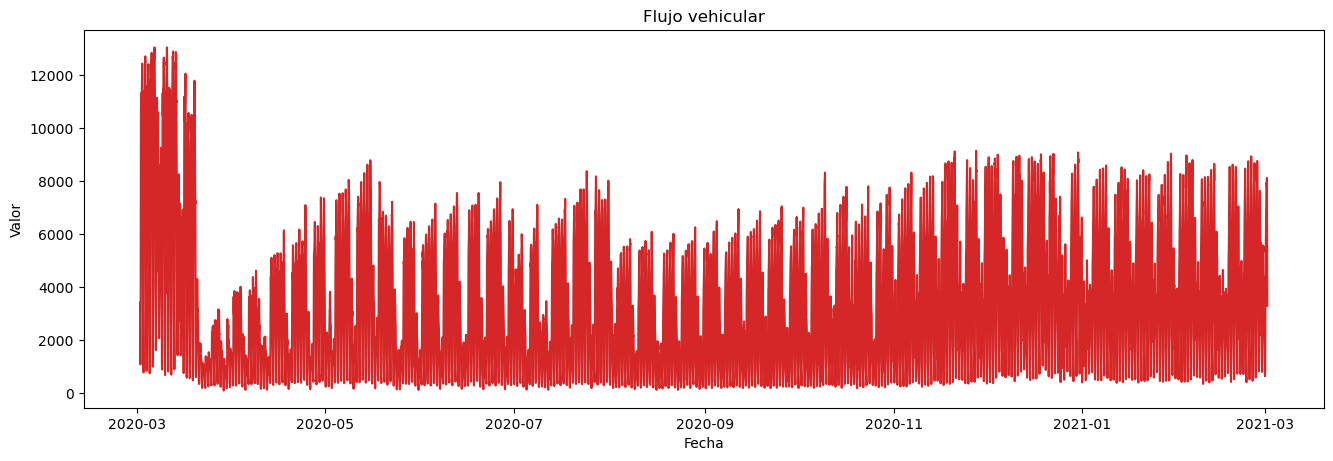

In [86]:
plot_df(data_v2, x=data_v2.HORA, y=data_v2.CANTIDAD,\
        title='Flujo vehicular')

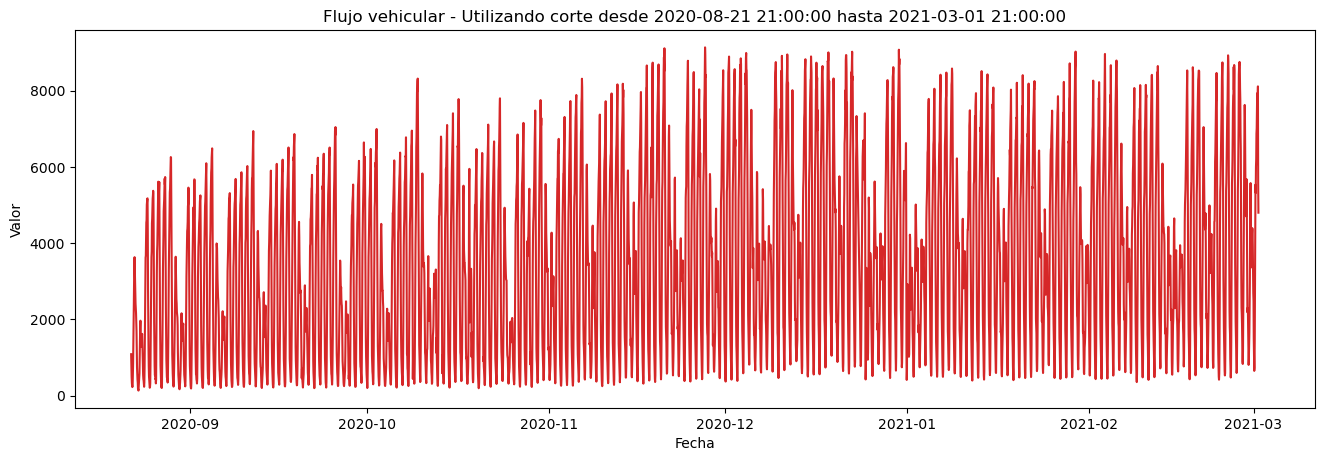

In [92]:
desde = '2020-08-21 21:00:00'
hasta = '2021-03-01 21:00:00'
corte_mask = (data_v2['HORA'] > desde)  & (data_v2['HORA'] < hasta)
plot_df(data_v2[corte_mask], x=data_v2.HORA[corte_mask], y=data_v2.CANTIDAD[corte_mask],\
        title='Flujo vehicular - Utilizando corte desde %s hasta %s' % (desde, hasta)) 

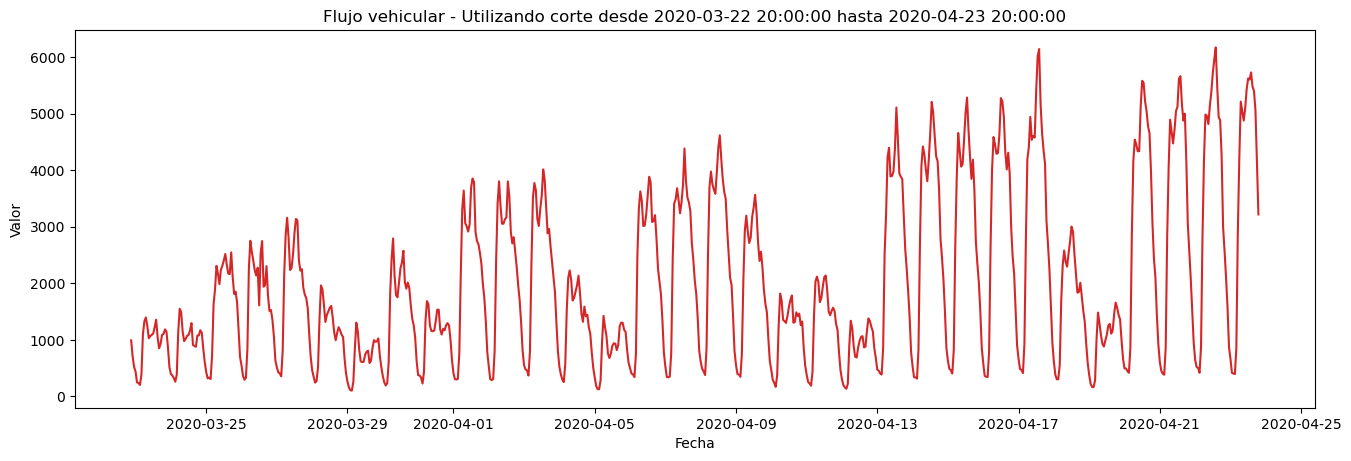

In [88]:
desde = '2020-03-22 20:00:00'
hasta = '2020-04-23 20:00:00'
corte_mask = (data_v2['HORA'] > desde)  & (data_v2['HORA'] < hasta)
plot_df(data_v2[corte_mask], x=data_v2.HORA[corte_mask], y=data_v2.CANTIDAD[corte_mask],\
        title='Flujo vehicular - Utilizando corte desde %s hasta %s' % (desde, hasta), xlabel='Fecha') 

In [89]:
#Reducimos el dataset solo al area de interes nuestra

desde = '2020-08-01 21:00:00'
hasta = '2021-03-01 21:00:00'
corte_mask = (data_v2['HORA'] > desde)  & (data_v2['HORA'] < hasta)

data_v2 = data_v2[corte_mask]

In [90]:
data_v2

,HORA,CANTIDAD,year,month
3670,2020-08-01 22:00:00,1111,2020,Aug
3671,2020-08-01 23:00:00,778,2020,Aug
3672,2020-08-02 00:00:00,663,2020,Aug
3673,2020-08-02 01:00:00,425,2020,Aug
3674,2020-08-02 02:00:00,303,2020,Aug
...,...,...,...,...
8738,2021-03-01 16:00:00,7844,2021,Mar
8739,2021-03-01 17:00:00,7822,2021,Mar
8740,2021-03-01 18:00:00,8118,2021,Mar
8741,2021-03-01 19:00:00,5604,2021,Mar


In [91]:
data_v2["timeIndex"] = pd.Series(np.arange(len(data_v2['CANTIDAD'])), index=data_v2.index)

data_v2.head()

# Comentario: recordá que la dummy de tiempo es una variable de apoyo que lleva la cuenta de
# la cantidad de periodos que pasan desde la primera observación. Sirve para poder hacer
# regresiones contra el tiempo y estimar la tendencia. 

,HORA,CANTIDAD,year,month,timeIndex
3670,2020-08-01 22:00:00,1111,2020,Aug,0
3671,2020-08-01 23:00:00,778,2020,Aug,1
3672,2020-08-02 00:00:00,663,2020,Aug,2
3673,2020-08-02 01:00:00,425,2020,Aug,3
3674,2020-08-02 02:00:00,303,2020,Aug,4


In [93]:
data_v2.tail()

,HORA,CANTIDAD,year,month,timeIndex
8738,2021-03-01 16:00:00,7844,2021,Mar,5068
8739,2021-03-01 17:00:00,7822,2021,Mar,5069
8740,2021-03-01 18:00:00,8118,2021,Mar,5070
8741,2021-03-01 19:00:00,5604,2021,Mar,5071
8742,2021-03-01 20:00:00,4801,2021,Mar,5072


In [94]:
dummies_mes = pd.get_dummies(data_v2['month'], drop_first=True)
data_v2 =  data_v2.join(dummies_mes)
data_v2.sample(10)

,HORA,CANTIDAD,year,month,timeIndex,Dec,Feb,Jan,Mar,Nov,Oct,Sep
8212,2021-02-07 18:00:00,3562,2021,Feb,4542,0,1,0,0,0,0,0
4874,2020-09-21 02:00:00,352,2020,Sep,1204,0,0,0,0,0,0,1
4570,2020-09-08 10:00:00,4082,2020,Sep,900,0,0,0,0,0,0,1
5612,2020-10-21 20:00:00,2444,2020,Oct,1942,0,0,0,0,0,1,0
4252,2020-08-26 04:00:00,412,2020,Aug,582,0,0,0,0,0,0,0
7872,2021-01-24 14:00:00,2737,2021,Jan,4202,0,0,1,0,0,0,0
3937,2020-08-13 01:00:00,314,2020,Aug,267,0,0,0,0,0,0,0
5599,2020-10-21 07:00:00,3191,2020,Oct,1929,0,0,0,0,0,1,0
3821,2020-08-08 05:00:00,601,2020,Aug,151,0,0,0,0,0,0,0
7401,2021-01-04 23:00:00,1618,2021,Jan,3731,0,0,1,0,0,0,0


In [95]:
# Separamos los datos de entrenamiento y testeo

data_train, data_test = train_test_split(data_v2, test_size=.2, random_state=42, shuffle=False)

In [96]:
display(data_train)
display(data_test)

,HORA,CANTIDAD,year,month,timeIndex,Dec,Feb,Jan,Mar,Nov,Oct,Sep
3670,2020-08-01 22:00:00,1111,2020,Aug,0,0,0,0,0,0,0,0
3671,2020-08-01 23:00:00,778,2020,Aug,1,0,0,0,0,0,0,0
3672,2020-08-02 00:00:00,663,2020,Aug,2,0,0,0,0,0,0,0
3673,2020-08-02 01:00:00,425,2020,Aug,3,0,0,0,0,0,0,0
3674,2020-08-02 02:00:00,303,2020,Aug,4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7723,2021-01-18 09:00:00,5210,2021,Jan,4053,0,0,1,0,0,0,0
7724,2021-01-18 10:00:00,5497,2021,Jan,4054,0,0,1,0,0,0,0
7725,2021-01-18 11:00:00,5973,2021,Jan,4055,0,0,1,0,0,0,0
7726,2021-01-18 12:00:00,6454,2021,Jan,4056,0,0,1,0,0,0,0


,HORA,CANTIDAD,year,month,timeIndex,Dec,Feb,Jan,Mar,Nov,Oct,Sep
7728,2021-01-18 14:00:00,6965,2021,Jan,4058,0,0,1,0,0,0,0
7729,2021-01-18 15:00:00,7227,2021,Jan,4059,0,0,1,0,0,0,0
7730,2021-01-18 16:00:00,7484,2021,Jan,4060,0,0,1,0,0,0,0
7731,2021-01-18 17:00:00,8032,2021,Jan,4061,0,0,1,0,0,0,0
7732,2021-01-18 18:00:00,6927,2021,Jan,4062,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8738,2021-03-01 16:00:00,7844,2021,Mar,5068,0,0,0,1,0,0,0
8739,2021-03-01 17:00:00,7822,2021,Mar,5069,0,0,0,1,0,0,0
8740,2021-03-01 18:00:00,8118,2021,Mar,5070,0,0,0,1,0,0,0
8741,2021-03-01 19:00:00,5604,2021,Mar,5071,0,0,0,1,0,0,0


In [97]:
# Transformamos los datos aplicando logaritmo
data_train['log_value'] = np.log(data_train['CANTIDAD'])
data_test['log_value'] = np.log(data_test['CANTIDAD'])



In [98]:
# Probar los datos elevandolos al cubo

data_train['x3_value'] = data_train.CANTIDAD.apply(lambda x: x**3)
data_test['x3_value'] = data_test.CANTIDAD.apply(lambda x: x**3)

In [99]:
data_train

,HORA,CANTIDAD,year,month,timeIndex,Dec,Feb,Jan,Mar,Nov,Oct,Sep,log_value,x3_value
3670,2020-08-01 22:00:00,1111,2020,Aug,0,0,0,0,0,0,0,0,7.013016,1371330631
3671,2020-08-01 23:00:00,778,2020,Aug,1,0,0,0,0,0,0,0,6.656727,470910952
3672,2020-08-02 00:00:00,663,2020,Aug,2,0,0,0,0,0,0,0,6.496775,291434247
3673,2020-08-02 01:00:00,425,2020,Aug,3,0,0,0,0,0,0,0,6.052089,76765625
3674,2020-08-02 02:00:00,303,2020,Aug,4,0,0,0,0,0,0,0,5.713733,27818127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,2021-01-18 09:00:00,5210,2021,Jan,4053,0,0,1,0,0,0,0,8.558335,141420761000
7724,2021-01-18 10:00:00,5497,2021,Jan,4054,0,0,1,0,0,0,0,8.611958,166102898473
7725,2021-01-18 11:00:00,5973,2021,Jan,4055,0,0,1,0,0,0,0,8.695005,213097102317
7726,2021-01-18 12:00:00,6454,2021,Jan,4056,0,0,1,0,0,0,0,8.772455,268835664664


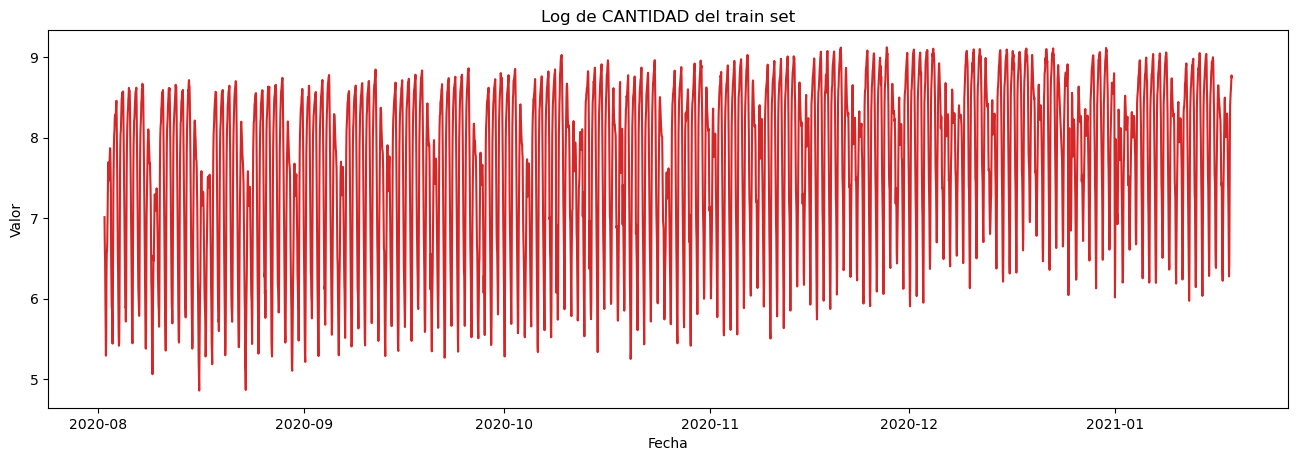

In [100]:
plot_df(data_train, x=data_train.HORA, y=data_train['log_value'],\
    title='Log de CANTIDAD del train set')

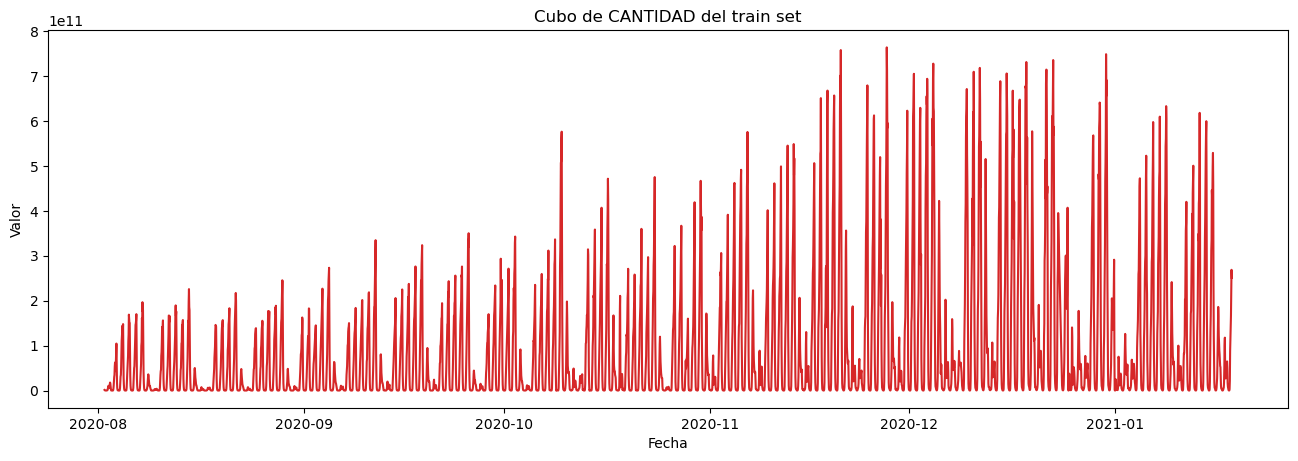

In [101]:
plot_df(data_train, x=data_train.HORA, y=data_train['x3_value'],\
    title='Cubo de CANTIDAD del train set')

In [102]:
model_log = smf.ols('log_value ~ timeIndex', data = data_train).fit()

In [103]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     328.7
Date:                Sat, 20 Mar 2021   Prob (F-statistic):           1.06e-70
Time:                        19:12:16   Log-Likelihood:                -5609.8
No. Observations:                4058   AIC:                         1.122e+04
Df Residuals:                    4056   BIC:                         1.124e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1957      0.030    237.704      0.000       7.136       7.255
timeIndex      0.0002   1.29e-05     18.130      0.000       0.000       0.000
==============================================================================
Omnibus:                      754.290   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.538
Skew:                          -0.509   Prob(JB):                     1.12e-69
Kurtosis:                       2.084   Cond. No.                     4.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [104]:
# Obtenemos las predicciones  del modelo
data_train['model_log'] = model_log.predict(data_train[["timeIndex"]])
data_test['model_log'] = model_log.predict(data_test[["timeIndex"]])

In [105]:
# Volvemos a 'transformar' los datos exponencialmente
data_train['back_model_log'] = np.exp(data_train['model_log'])
data_test['back_model_log'] = np.exp(data_test['model_log'])

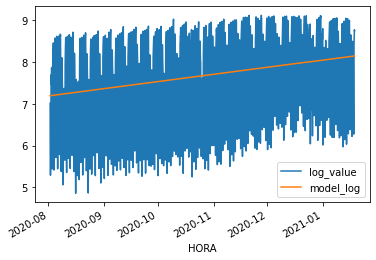

In [106]:
# Ploteamos los datos transformados y la predccion
data_train.plot(kind = "line", x = "HORA", y = ['log_value', 'model_log']);

<AxesSubplot:xlabel='HORA'>

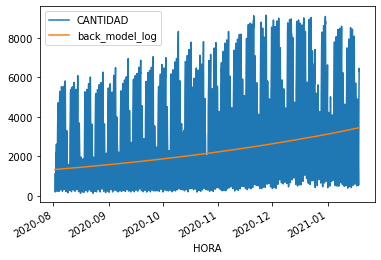

In [107]:
# Ploteamos los datos originales y la prediccion
data_train.plot(kind = "line", x = "HORA", y = ['CANTIDAD', 'back_model_log'])

<AxesSubplot:xlabel='HORA'>

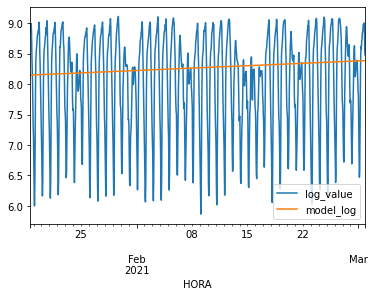

In [108]:
data_test.plot(kind = "line", x = "HORA", y = ['log_value', 'model_log'])

<AxesSubplot:xlabel='HORA'>

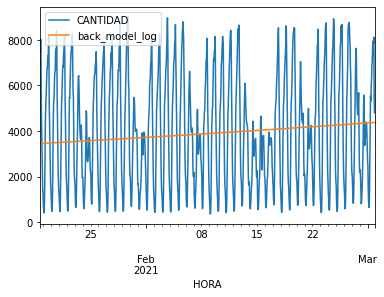

In [109]:
data_test.plot(kind = "line", x = "HORA", y = ['CANTIDAD', 'back_model_log'])

In [110]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [111]:
data_Results = pd.DataFrame(columns = ["Model", "RMSE"])
data_Results.loc[0, "Model"] = "Log"
data_Results.loc[0, "RMSE"] = RMSE(data_test.back_model_log, data_test.CANTIDAD)
data_Results

,Model,RMSE
0,Log,2473.92


In [117]:
# Agregamos estacionalidad mensual
model_log_est = smf.ols('log_value ~ timeIndex + Dec + Feb	+ Jan + Mar + Nov + Oct + Sep',\
                          data = data_train).fit()


In [118]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     59.00
Date:                Sat, 20 Mar 2021   Prob (F-statistic):           2.74e-70
Time:                        19:19:04   Log-Likelihood:                -5597.9
No. Observations:                4058   AIC:                         1.121e+04
Df Residuals:                    4051   BIC:                         1.125e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2008      0.045    160.838      0.000       7.113       7.289
timeIndex      0.0002   7.45e-05      2.879      0.004    6.85e-05       0.000
Dec            0.1588      0.223      0.713      0.476      -0.278       0.595
Feb        -1.742e-16   1.12e-16     -1.550      0.121   -3.95e-16    4.61e-17
Jan           -0.0911      0.266     -0.342      0.732      -0.614       0.431
Mar         4.001e-16   4.32e-16      0.927      0.354   -4.46e-16    1.25e-15
Nov            0.0980      0.171      0.575      0.566      -0.236       0.432
Oct           -0.0146      0.119     -0.123      0.902      -0.249       0.219
Sep            0.0051      0.074      0.070      0.945      -0.140       0.150
==============================================================================
Omnibus:                      764.717   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.491
Skew:                          -0.508   Prob(JB):                     1.14e-69
Kurtosis:                       2.080   Cond. No.                     9.99e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.23e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [119]:
# Calculamos las predicciones
data_train['model_log_est'] = model_log_est.predict(data_train[["timeIndex",\
                                              "Dec", "Jan", "Nov", "Oct", "Sep"]])


data_test['model_log_est'] = model_log_est.predict(data_test[["timeIndex",\
                                              "Dec", "Jan", "Nov", "Oct", "Sep"]])

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'Feb' is not defined
    log_value ~ timeIndex + Dec + Feb	+ Jan + Mar + Nov + Oct + Sep
                                  ^^^

In [120]:
data_train['back_model_log_est'] = np.exp(data_train['model_log_est'])
data_test['back_model_log_est'] = np.exp(data_test['model_log_est'])

KeyError: 'model_log_est'

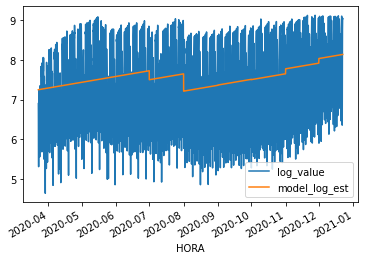

In [61]:
data_train.plot(kind = "line", x = "HORA", y = ['log_value', 'model_log_est']);

<AxesSubplot:xlabel='HORA'>

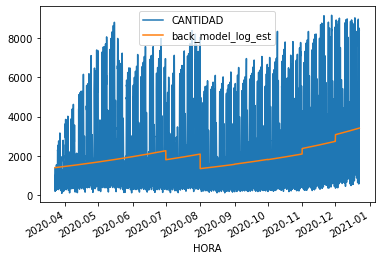

In [62]:
data_train.plot(kind = "line", x = "HORA", y = ['CANTIDAD', 'back_model_log_est'])

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


In [35]: cities.plot(ax=ax, marker='o', color='red', markersize=5)

In [36]: plt.show();